## 1. (Convolutional) Autoencoder with MNIST dataset

1) Import Libraries

In [4]:
# AE.ipynb
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import torch
from torchvision import datasets
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F

2) CUDA Setting

In [5]:
# CUDA setting
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"CUDA GPU : {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')

CUDA GPU : NVIDIA GeForce RTX 4070 Ti SUPER


3) Dataset Download & Parse

In [6]:
# Dataset download (MNIST)

BATCH_SIZE = 512

train_data = datasets.MNIST('./data', train=True, download=True, transform=transforms.ToTensor())
test_data =  datasets.MNIST('./data', train=False, download=True, transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
test_loader =  torch.utils.data.DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)

4) Model Archtecture & structure

In [9]:
# Model implement : Autoencoder
# Input tensor : (batch_size, 1, 28, 28) & Output : (batch_size)

# Architecture : 1x28x28 -> (filtersize:4, stride:2, padding:0 ) -> 1x13x13 -> 1x28x28

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1), # 1x28x28 -> 32x14x14
            nn.ReLU(),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1), # 32x14x14 -> 64x7x7
            nn.ReLU(),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=7), # 64x7x7 -> 64x1x1
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=7),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),

            nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1)
        )
    
    def forward(self, x):
        x = self.encoder(x)
        # x.shape == (batch, 64, 1, 1)
        latent_x = x
        x = self.decoder(x)

        return x, latent_x

5) Training defined model

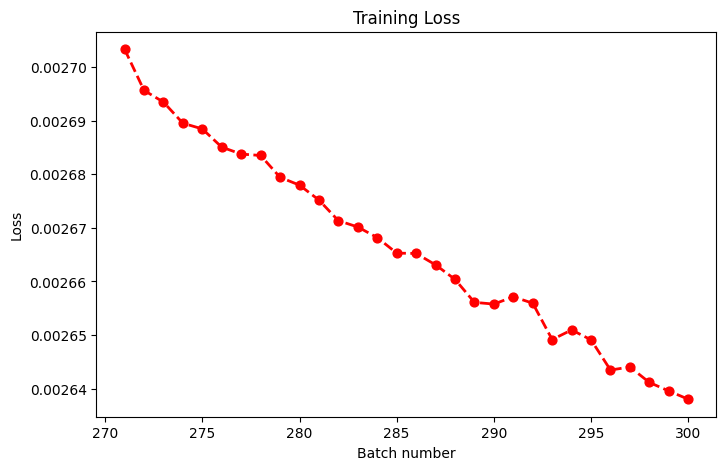

100%|█████████████████████████████████████████████████████████████████████████████████| 300/300 [03:11<00:00,  1.57it/s]


In [6]:
# Model Training
from IPython import display

model = Autoencoder().to(device)

epoch = 300

learning_rate = 2E-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

losses = []

for epoch_idx in trange(epoch):
    model.train()

    running_loss = 0.0
    total_batches = 0

    for (x_train, _) in train_loader:
        x_train = x_train.to(device)
        output, __ = model(x_train)
        
        loss = loss_fn(x_train, output)
        running_loss += loss.item()
        total_batches += 1

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    losses.append(running_loss / total_batches)

    display.clear_output(wait=True)
    plt.figure(figsize=(8, 5))

    xrange = [i for i in range(1, epoch_idx+2)]
    if len(xrange) > 30:
        xrange = xrange[-30:]
        yrange = losses[xrange[0]-1:xrange[-1]]
    else:
        yrange = losses[:]
    
    plt.plot(xrange,yrange, linestyle='--', linewidth=2, c='r')
    plt.scatter(xrange, yrange, c='red', s=40)
    plt.xlabel('Batch number')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()


6) Visualization of my model

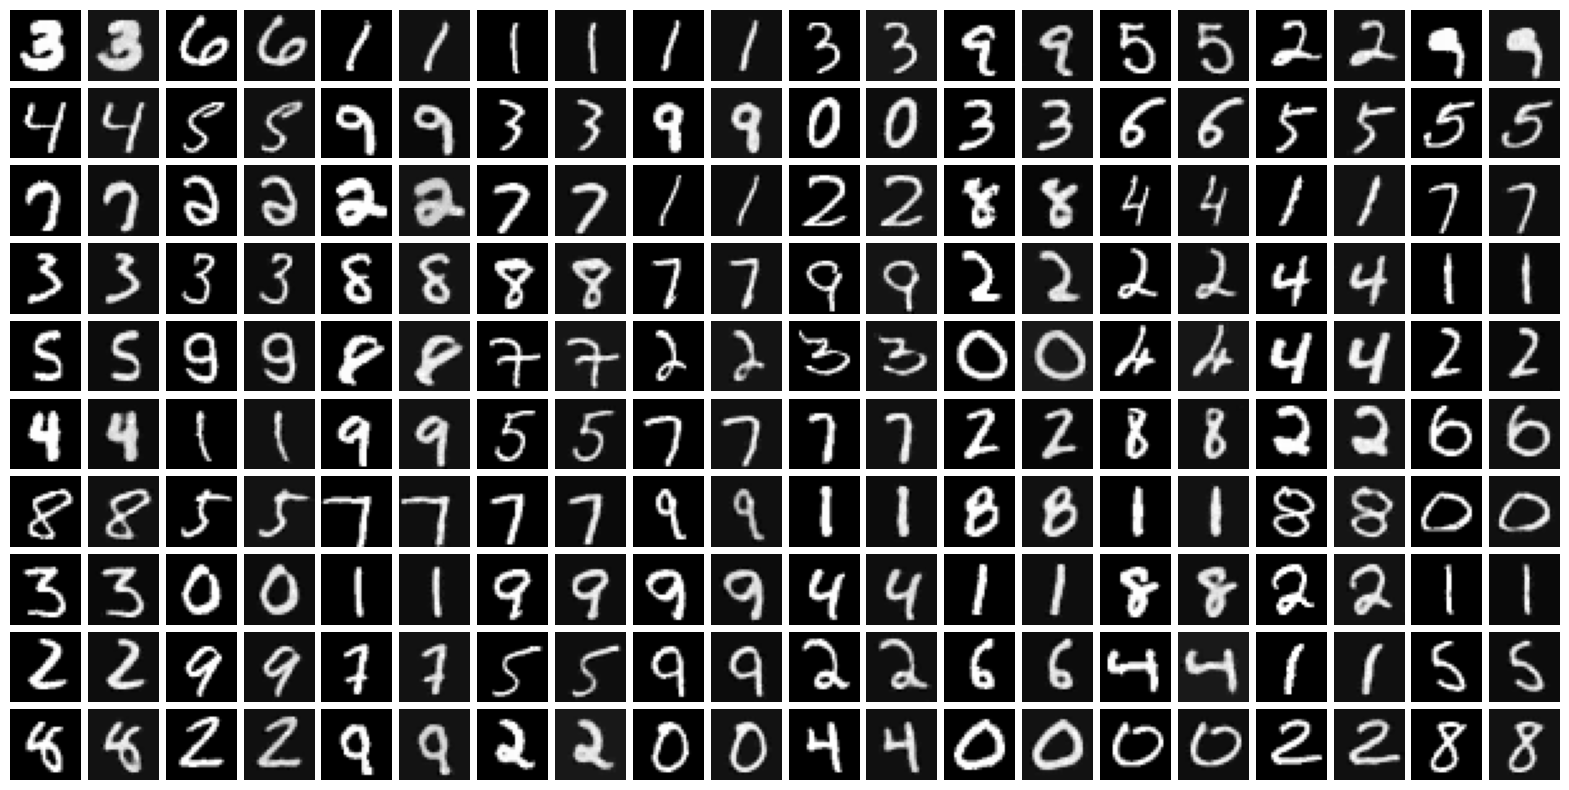

In [20]:
import matplotlib.pyplot as plt
import torch

start_idx = 200
num_pairs = 100
pairs_per_row = 10

plt.figure(figsize=(20, 10))

for i in range(num_pairs):
    row = i // pairs_per_row
    col = i % pairs_per_row

    # Original Image
    plt.subplot(10, 20, 2 * col + 1 + 20 * row)
    data = test_data[start_idx + i][0]
    img = data.reshape(28, 28)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    # Reconstructed Image
    plt.subplot(10, 20, 2 * col + 2 + 20 * row)
    with torch.no_grad():
        reconstructed_images, _ = model(data.unsqueeze(0).to(device))
    reconstructed_images = reconstructed_images.cpu()
    plt.imshow(reconstructed_images.squeeze().reshape(28, 28), cmap='gray')
    plt.axis('off')

plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.show()


7) Saving Model Weights

In [5]:
# print(f"Result loss : {losses[-1]}")
torch.save(model, "./1. Autoencoder/Autoencoder_MNIST.pt") # Why not ./Autoencoder_MNIST.pt??

## 2. 2D Modeling (decomposition)

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1859.40it/s]


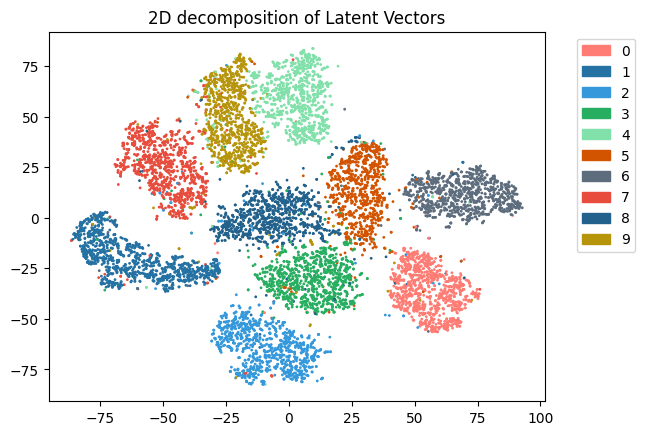

In [64]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

model = torch.load("./Autoencoder_MNIST.pt", map_location=device)
model.eval()

latent_vectors = []
label = []
colors = ['#fe7c73', '#2471A3', '#3498DB', '#27AE60', '#82E0AA', '#D35400', '#5D6D7E', '#E74C3C', '#21618C', '#B7950B']

for (X, y) in tqdm(test_data):
    with torch.no_grad():
        _, latent_x = model(X.to(device))
        latent_vectors.append(latent_x.reshape(64).cpu().numpy())
    label.append(y)

color_labeled = [colors[label[i]] for i in range(len(label))]
all_latent_vectors = np.vstack(latent_vectors)

# decomposition_model = PCA(n_components=2) # Not that good performance..
decomposition_model = TSNE(n_components=2)
latent_2d = decomposition_model.fit_transform(all_latent_vectors)

patches = [mpatches.Patch(color=colors[i], label=f'{i}') for i in range(len(colors))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=1, c = color_labeled)
plt.title('2D decomposition of Latent Vectors')
plt.show()

Actually, I wanted to show the shortcut of the Vanila Autoencoder.

The Vanila Autoencoder have shortcuts below.

- Hard to analysis the latent space from AE.

- The generated latent space is not continuous.

- The equality of the generated result low.

So this shortcuts lead us to VAE (Variational Autoencoder)


This is a blog for more details : https://medium.com/@hugmanskj/autoencoder-%EC%99%80-variational-autoencoder%EC%9D%98-%EC%A7%81%EA%B4%80%EC%A0%81%EC%9D%B8-%EC%9D%B4%ED%95%B4-171b3968f20b

# Can we use Autoencoder as generative model??

In [2]:
import os
os.chdir('./1. Autoencoder/')

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:04<00:00, 2015.46it/s]


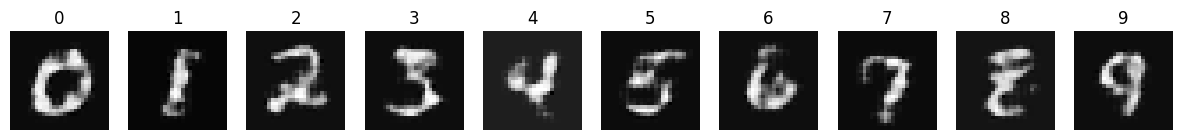

In [69]:
model = torch.load("./Autoencoder_MNIST.pt", map_location=device)
model.eval()

label_latent_vectors = [torch.zeros(64).to(device) for _ in range(10)]
label_num = [0 for _ in range(10)]

for (X, y) in tqdm(test_data):
    with torch.no_grad():
        _, latent_x = model(X.to(device))
        label_latent_vectors[y] += latent_x.view(64)
        label_num[y] += 1


noise_std = 1
label_latent_vectors = [(label_latent_vectors[i] / label_num[i] + noise_std * torch.randn(64).to(device)).view(64, 1, 1) for i in range(10)]
label_mean_img = []

with torch.no_grad():
    for i in range(10):
        label_mean_img.append(model.decoder(label_latent_vectors[i]).cpu())

fig, axes = plt.subplots(1, 10, figsize=(15, 2))

for i in range(10):
    axes[i].imshow(label_mean_img[i].view(28, 28), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(str(i))

plt.show()

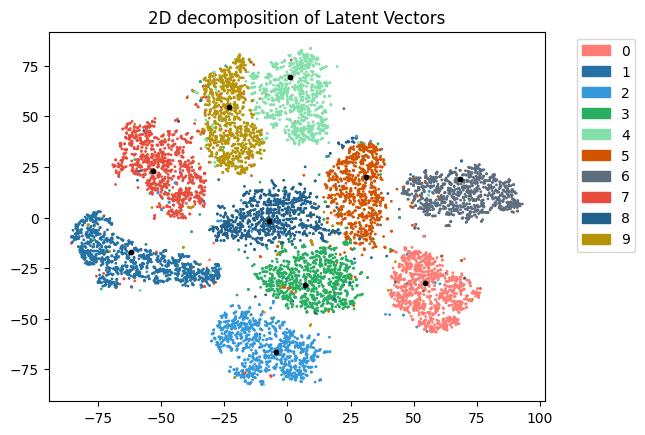

In [70]:
assert len(all_latent_vectors) == 10000

reshaped_label_latent_vectors = np.array([llv.view(64).cpu() for llv in label_latent_vectors])
new_latent_vectors = np.vstack([all_latent_vectors, reshaped_label_latent_vectors])


decomposition_model = TSNE(n_components=2)
latent_2d = decomposition_model.fit_transform(new_latent_vectors)

patches = [mpatches.Patch(color=colors[i], label=f'{i}') for i in range(len(colors))]
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=1, c = color_labeled)
plt.scatter(latent_2d[:, 0][-10:], latent_2d[:, 1][-10:], s = 10, c = 'black')

plt.title('2D decomposition of Latent Vectors')
plt.show()

This results shows us that AE is not enough to use as generative model. 


I constructed the new latent vector using mean of the label's latent vector, and summing little noise.

But the result of the reconstucted image is not that clear even the latent vector was obviously in the 2d cluster.

So, this means the Autoencoder cannot be used as generative model, stem from the **discreteness**.


(If the input of the model becomes LARGE & COMPLICATED, this shortcuts will stand out more.)